# Flares in LSST Fields

*A few summary figures*

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flare_prob
import toymodel

In [6]:
# let's read in the Trilegal field, and see the columns

# l=45, b=-40, fov=3.5
file = 'trilegal_models/output164538496014.dat'
df = pd.read_table(file, sep=r"\s*", engine='python')
df

,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,m2/m1,mbol,u,g,r,i,z,Mact
0,1,6.71,-0.09,1.48300,0.704,3.866,4.316,12.0,0.038,0.00,15.009,16.159,15.118,15.020,15.070,15.161,1.483
1,1,6.71,0.05,0.10445,-1.890,3.488,4.246,8.2,0.035,0.00,17.696,24.385,21.152,19.589,18.162,17.330,0.104
2,1,6.71,0.21,0.09747,-1.937,3.478,4.222,8.0,0.034,0.00,17.613,24.592,21.261,19.670,18.147,17.261,0.097
3,1,6.81,0.13,0.32971,-1.837,3.560,4.978,8.6,0.036,0.00,17.961,23.016,20.304,18.937,18.056,17.537,0.330
4,1,6.87,0.07,0.39928,-1.642,3.574,4.924,12.6,0.038,0.00,21.476,26.204,23.660,22.342,21.525,21.040,0.399
5,1,6.91,-0.23,0.28343,-1.912,3.571,5.031,8.7,0.036,0.80,17.705,22.626,19.898,18.492,17.735,17.283,0.283
6,1,6.95,0.05,0.02500,-2.768,3.390,4.110,6.2,0.024,0.00,17.890,26.818,23.345,21.706,19.405,17.870,0.025
7,1,7.07,-0.05,0.07481,-2.175,3.472,4.323,9.2,0.037,0.87,18.785,26.164,22.649,21.018,19.391,18.455,0.075
8,1,7.09,0.01,0.20817,-2.208,3.541,5.075,12.1,0.038,0.00,22.390,27.871,24.976,23.544,22.554,21.973,0.208
9,1,7.09,0.31,0.02338,-2.876,3.375,4.127,9.7,0.038,0.00,21.661,31.353,27.562,25.855,23.416,21.741,0.023


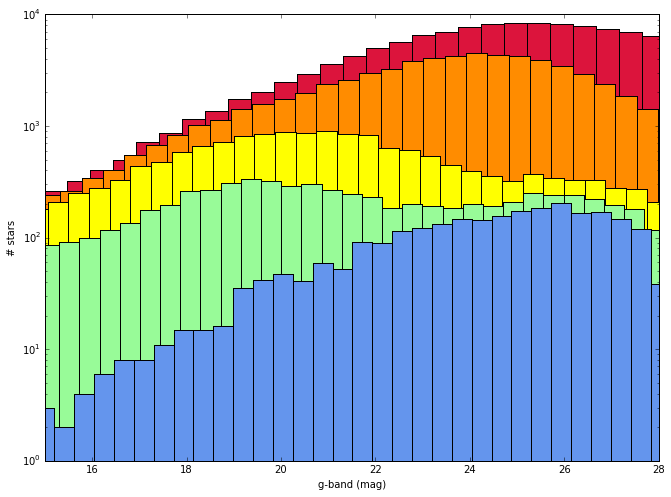

In [28]:
# make a histogram of # of stars versus Apparent Mag in each temperature bin (3k to 7k)
Teff_bins = np.log10(np.arange(3000,8000,1000))

fov = 3.5 # sq deg (size of Trilegal field)

clrs = ['crimson','darkorange','yellow','palegreen','cornflowerblue']

plt.figure(figsize=(11,8))
for k in range(len(Teff_bins)):
    x = np.where((df['logg'] >= 4) & (df['logTe'] >= Teff_bins[k]) & (df['logTe'] < Teff_bins[k]+1000))
    _ = plt.hist(df['g'].values[x], bins=50, color=clrs[k])
plt.yscale('log')
plt.xlim(15,28)
plt.xlabel('g-band (mag)')
plt.ylabel('# stars')

In [32]:
s_time1, s_flux1 = flare_prob.SuperLC(dur=0.05, repeat=200, mag=True)

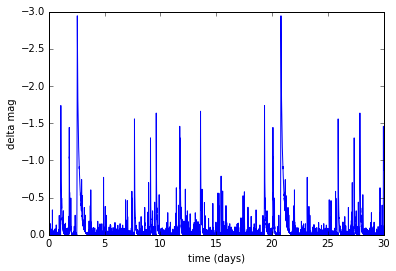

In [37]:
plt.plot(s_time1, s_flux1)
plt.xlim(0,30)
plt.ylim((0,-3))
plt.xlabel('time (days)')
plt.ylabel('delta mag')

In [ ]:
dmag_limit = -0.1 # flare detection threshold

ntrials = 1000

npass = np.zeros(ntrials)

for k in range(ntrials):
    t,f = toymodel.downsample(s_time1, s_flux1)
    ok = np.where((f <= dmag_limit))